# SciKit Logistic Regression Demo

This notebook shows the [logistic regression demo](./LogitRegressionDemo.ipynb) with SciKit-Learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) instead of StatsModels.

## Setup

Let's import some packages:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.special import logit
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression

In [2]:
rng = np.random.RandomState(20201024)

## Read Data

Load the UCLA grad admissions data.

In [3]:
students = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
students.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Let's train and test:

In [4]:
test = students.sample(frac=0.2, random_state=rng)

In [5]:
train_mask = pd.Series(True, index=students.index)
train_mask[test.index] = False
train = students[train_mask].copy()
train.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
3,1,640,3.19,4
7,0,400,3.08,2
8,1,540,3.39,3


## Train the Model

Let's create our logistic regression model.  `penalty='none'` will turn off regularization:

In [6]:
lg_mod = LogisticRegression(penalty='none')

Now we need to train (or `fit`) the model.  SciKit-Learn doesn't know about Pandas; it works on NumPy arrays and matrices.  Fortunately, a Pandas data frame is a matrix, but we need to separate out the predictors and outcome:

In [7]:
feat_cols = ['gre', 'gpa', 'rank']
out_col = 'admit'
train_x = train[feat_cols]
train_y = train[out_col]

Now we can call `fit`.  Unlike Statsmodels, SciKit-Learn doesn't have separate model and results objects.  We just call `fit`, which trains the model in-place:

In [8]:
lg_mod.fit(train_x, train_y)

LogisticRegression(penalty='none')

We can get the coefficients from it:

In [9]:
lg_mod.coef_

array([[ 0.00201959,  0.88632881, -0.57805603]])

And the intercept:

In [10]:
lg_mod.intercept_

array([-3.60332028])

The SciKit-Learn convention is that parameters estimated by the `fit` process are stored in fields ending in `_`.

Let's quick train one with statsmodels just to see that it's training the same thing:

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
smf.glm('admit ~ gre + gpa + rank', train, family=sm.families.Binomial()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  320
Model:                            GLM   Df Residuals:                      316
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -184.48
Date:                Sat, 24 Oct 2020   Deviance:                       368.97
Time:                        21:11:55   Pearson chi2:                     318.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6033      1.286     -2.802      0.005      -6.124      -1.083
gre            0.0020      0.001      1.620      0.105      -0.000       0.004
gpa            0.8863      0.372      2.384      0.017       0.158       1.615
rank          -0.5781      0.144     -4.022      0.000      -0.860      -0.296
==============================================================================
"""

Let's compute our training set accuracy.  SciKit-Learn's `predict` method outputs the *class*, not the score, so it is directly 1/0.  Let's compute that, and compare to `train_y`:

In [12]:
train_d = lg_mod.predict(train_x)
np.mean(train_d == train_y)

0.7125

It's using a probability of 0.5 - more likely than not - as the decision boundary.  More formally, it is using the *log odds*: $\operatorname{log} \operatorname{Odds}(A) > 0$

It returns the positive class (1 in our case) if that quantity is greater than 0.

If we want the probabilities, we can call `predict_proba`:

In [13]:
lg_mod.predict_proba(train_x)

array([[0.79744403, 0.20255597],
       [0.67955536, 0.32044464],
       [0.85761431, 0.14238569],
       [0.77236289, 0.22763711],
       [0.77595587, 0.22404413],
       [0.46787112, 0.53212888],
       [0.68017007, 0.31982993],
       [0.60796732, 0.39203268],
       [0.28929082, 0.71070918],
       [0.64926804, 0.35073196],
       [0.7890339 , 0.2109661 ],
       [0.71303456, 0.28696544],
       [0.91225083, 0.08774917],
       [0.45512696, 0.54487304],
       [0.42895462, 0.57104538],
       [0.82024802, 0.17975198],
       [0.55209187, 0.44790813],
       [0.9006386 , 0.0993614 ],
       [0.33664913, 0.66335087],
       [0.43280414, 0.56719586],
       [0.55358476, 0.44641524],
       [0.69707229, 0.30292771],
       [0.75254157, 0.24745843],
       [0.54401017, 0.45598983],
       [0.66178295, 0.33821705],
       [0.77700399, 0.22299601],
       [0.53231559, 0.46768441],
       [0.84773499, 0.15226501],
       [0.72619966, 0.27380034],
       [0.87123671, 0.12876329],
       [0.

It returns the probability of *each class*.  Since this is binary, each row will sum to 1.

Let's make sure the classes are in the order we expect:

In [14]:
lg_mod.classes_

array([0, 1], dtype=int64)

Now we can just get the probability of 1 and save it:

In [15]:
lg_mod.decision_function(train_x)

array([-1.37039542e+00, -7.51729186e-01, -1.79561494e+00, -1.22170176e+00,
       -1.24225261e+00,  1.28692834e-01, -7.54553462e-01, -4.38775908e-01,
        8.98830850e-01, -6.15823364e-01, -1.31911185e+00, -9.10168099e-01,
       -2.34143256e+00,  1.79976401e-01,  2.86117553e-01, -1.51802873e+00,
       -2.09126306e-01, -2.20434038e+00,  6.78262841e-01,  2.70419364e-01,
       -2.15165319e-01, -8.33394940e-01, -1.11221364e+00, -1.76497429e-01,
       -6.71249784e-01, -1.24829162e+00, -1.29442793e-01, -1.71694562e+00,
       -9.75425854e-01, -1.91193796e+00, -1.48354363e+00, -6.45455808e-01,
       -7.55739813e-01, -1.39394270e+00, -7.39909397e-01, -1.35064045e+00,
       -5.21369775e-01, -2.27335053e+00, -2.82882732e+00, -6.23718606e-01,
       -2.25271360e+00, -1.43411629e+00, -4.87812784e-01, -1.04421769e+00,
       -2.97673108e-01, -1.37912648e+00, -1.96423572e+00, -7.16494339e-01,
       -2.20434038e+00, -6.88758055e-01, -1.84195977e+00, -7.92121079e-01,
       -5.51798108e-01, -

In [16]:
train['score'] = lg_mod.predict_proba(train_x)[:, 1]
train

,admit,gre,gpa,rank,score
0,0,380,3.61,3,0.202556
1,1,660,3.67,3,0.320445
3,1,640,3.19,4,0.142386
7,0,400,3.08,2,0.227637
8,1,540,3.39,3,0.224044
...,...,...,...,...,...
395,0,620,4.00,2,0.509507
396,0,560,3.04,3,0.180631
397,0,460,2.63,2,0.182519
398,0,700,3.65,2,0.472374


We can get the log odds ratio itself with `decision_function`:

In [17]:
lg_mod.decision_function(train_x)

array([-1.37039542e+00, -7.51729186e-01, -1.79561494e+00, -1.22170176e+00,
       -1.24225261e+00,  1.28692834e-01, -7.54553462e-01, -4.38775908e-01,
        8.98830850e-01, -6.15823364e-01, -1.31911185e+00, -9.10168099e-01,
       -2.34143256e+00,  1.79976401e-01,  2.86117553e-01, -1.51802873e+00,
       -2.09126306e-01, -2.20434038e+00,  6.78262841e-01,  2.70419364e-01,
       -2.15165319e-01, -8.33394940e-01, -1.11221364e+00, -1.76497429e-01,
       -6.71249784e-01, -1.24829162e+00, -1.29442793e-01, -1.71694562e+00,
       -9.75425854e-01, -1.91193796e+00, -1.48354363e+00, -6.45455808e-01,
       -7.55739813e-01, -1.39394270e+00, -7.39909397e-01, -1.35064045e+00,
       -5.21369775e-01, -2.27335053e+00, -2.82882732e+00, -6.23718606e-01,
       -2.25271360e+00, -1.43411629e+00, -4.87812784e-01, -1.04421769e+00,
       -2.97673108e-01, -1.37912648e+00, -1.96423572e+00, -7.16494339e-01,
       -2.20434038e+00, -6.88758055e-01, -1.84195977e+00, -7.92121079e-01,
       -5.51798108e-01, -

## Analysis with Test Data

Now we'll predict our test data:

In [18]:
test_x = test[feat_cols]
test_y = test[out_col]

In [19]:
test_d = lg_mod.predict(test_x)

What's the accuracy?

In [20]:
np.mean(test_y == test_d)

0.7

**Practice:** compute the precision and recall.

## ROC Curve

We can plot the *receiver operating characteristic* by using the SciKit `roc_curve` function to compare outcomes and the decision function. It returns the `tpr` and `fpr`:

In [21]:
test_lo = lg_mod.decision_function(test_x)

In [22]:
fpr, tpr, thresh = sklearn.metrics.roc_curve(test_y, test_lo)

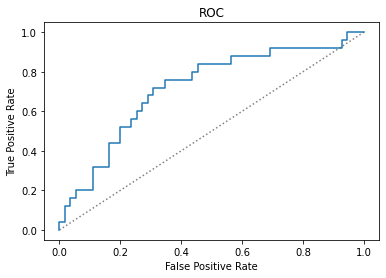

In [23]:
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='grey', linestyle=':')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

What's the area under that curve?

In [24]:
sklearn.metrics.roc_auc_score(test_y, test_lo)

0.7170909090909092

I'm going to fill it now for the slide demo:

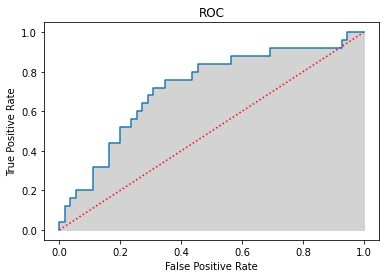

In [25]:
plt.fill_between(fpr, tpr, 0, color='lightgrey')
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='red', linestyle=':')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

Let's see a *precision-recall curve*:

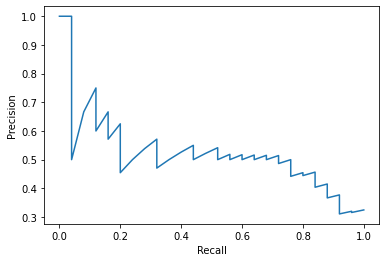

In [27]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test_y, test_lo)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Precision vs. Threshold

What if we decrease the threshold?

In [28]:
def precision_at_threshold(thresh):
    mask = test_lo >= thresh
    # mask will select for positive class
    # mean is fraction
    return np.mean(test_y[mask])

In [29]:
thresh = np.linspace(-2, 1, 20)
precs = [precision_at_threshold(p) for p in thresh]

Text(0, 0.5, 'Precision')

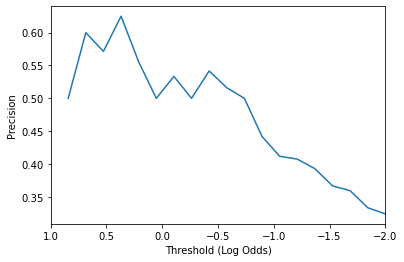

In [30]:
plt.plot(thresh, precs)
plt.xlim(1, -2)
plt.xlabel('Threshold (Log Odds)')
plt.ylabel('Precision')